## Lab 6: Time Series Analysis

**Purpose** : The purpose of this lab is to establish a foundation for time series analysis of remotely sensed data, usually in the form of a temporally ordered stack of images.  You will be introduced to concepts of smoothing, interpolation, linear modeling and phenology.  At the completion of the lab, you will be able to perform analysis of multi-temporal data for determining trend and seasonality on a per-pixel basis.

**Prerequisites** : Lab 5

### 1. Multi-temporal data in Earth Engine

Time series in Earth Engine are represented as image collections.  This can make time series analysis complicated because

- There is a different time series in each pixel
- The size (length) of the time series vary across pixels
- Missing data may occur in any pixel at any time (e.g. due to cloud masking)

As a result of these complicating factors, analyzing time series in Earth Engine is unlike traditional methods.  Specifically, use joins to define temporal relationships between collection items.  As you will soon discover, it's possible to perform many traditional time series methods by mapping functions over joined collections.

First, some very basic notation.  A scalar pixel at time *t* is given by $p_{t}$ and a pixel vector by $P_{t}$.  An estimate is a variable with a hat on: e.g. the estimated pixel value at time is $p̂_{t}$.  A time series is just a collection of *N* pixels, sorted chronologically: ${ P_{t}; t = t_{0}...t_{N}}$, where *t* might be in any units, $t_{0}$ is the smallest and $t_{N}$ is the largest such *t* in the series.

### 2. Data preparation and preprocessing

The first step in analysis of time series data is to import data of interest and plot it at an interesting location.

a. **Load a time series of Landsat data**

- Search for Landsat 8 surface reflectance and import the &quot;USGS Landsat 8 Surface Reflectance Tier 1&quot; collection.  Name it l8sr.

- Make a single point geometry with the geometry drawing tools and position the point in a location of interest.  (How about an annual grassland or a deciduous forest?)  Name the import roi.

b. **Filtering, masking and preparing bands of interest**

- preprocess the Landsat imagery by filtering it to the location of interest, masking clouds, and adding the variables in the model:

In [105]:
# Initializing display and earthengine
from IPython.display import Image
%matplotlib inline

import ee
ee.Initialize()

# importing ipygee for dynamic mapping
from ipygee import *
# import geetools for cloud /sadow discrimination
from geetools import ui, cloud_mask

Map = Map() # from ipygee
Map.show()

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [106]:
import datetime
from matplotlib import dates
import matplotlib.dates as mdates
from pylab import *

In [107]:
l8sr = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")

In [108]:
roi = ee.Geometry.Point([-122.977389, 38.753458]) 
Map.addLayer(roi, {'outline_color':'red'}, name='Region of Interest - ROI')

In [109]:
# // This field contains UNIX time in milliseconds.
timeField = 'system:time_start';

using Landsat BQA layer

In [110]:
# CLOUD MASKING IN EE PYTHON NOT QUITE EASY. USING THE GEETOOLS custom functions https://github.com/gee-community/gee_tools 

# this function only for Landsat 8 Surface Corrected single image
mask_l8SR_all = cloud_mask.landsatSR() #this function masks clouds, snow, shadows

# mask_l8SR_cloud = cloud_mask.landsatSR(['cloud'])
# mask_l8SR_shadow = cloud_mask.landsatSR(['shadow'])
# mask_l8SR_snow = cloud_mask.landsatSR(['snow'])

In [111]:
# creating a function for masking the entire ImmageCollection
def maskL8sr(image):
    cld_free=mask_l8SR_all(image)
    return cld_free

In [112]:
# // Use this function to add variables for NDVI, time and a constant
# // to Landsat 8 imagery.
def addVariables(image):
#   // Compute time in fractional years since the epoch.
    date = ee.Date(image.get(timeField))
    years = date.difference(ee.Date('1970-01-01'), 'year')
#   // Return the image with the added bands.
    return image.\
    addBands(image.normalizedDifference(['B5', 'B4']).rename('NDVI')).\
    addBands(ee.Image(years).rename('t')).\
    float().\
    addBands(ee.Image.constant(1))


# // Remove clouds, add variables and filter to the area of interest.
filteredLandsat = l8sr.\
  filterBounds(roi).\
  map(maskL8sr).\
  map(addVariables)

c. **Plot the time series at the location of interest**

- To visualize the data, make a chart at the location of interest.  

In [113]:
info = filteredLandsat.getRegion(roi,30).getInfo()# 30 is Landsat resolution



We separate the information returned into column headers and data.

In [114]:
# extract the header column names
print(info[0])
header = info[0]
# create a Numpy array of the data
data = array(info[1:])

['id', 'longitude', 'latitude', 'time', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'sr_aerosol', 'pixel_qa', 'radsat_qa', 'NDVI', 't', 'constant']


Next we extract time information and convert it to at Python datatime data type.

In [115]:
# extract the time information
iTime = header.index('time')
# convert to Python datetime objects
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

Extract the data columns what we want to display on the plot.

In [116]:
xBand = 'time'
yBandList = [
        'NDVI',
        u'B10' #B10 is a thermal band in Landsat
        ]

In [117]:
iBands = [header.index(b) for b in yBandList]
yData = data[0:,iBands].astype(np.float)

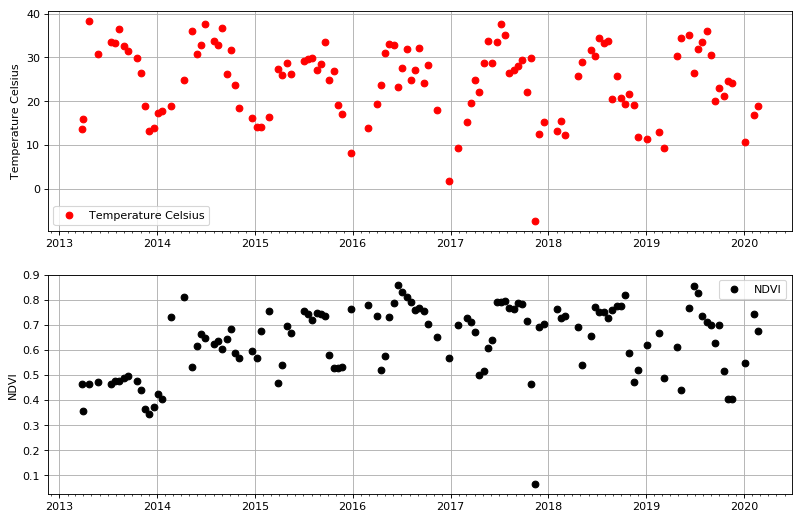

In [118]:
# matplotlib date format object

fig = figure(figsize=(12,8), dpi=80)

# plot the band values
ax1 = fig.add_subplot(211)
ax1.plot(time, yData[:,-1]*0.1-273.15, 'o', color="red", label="Temperature Celsius")
# ax1.plot(time, yData[:,3], 'o', color="magenta",  label="Band 4")
ax1.legend(loc='best')
ax1.grid(True)

#plt.title('Band values as a function of time')
ax1.set_ylabel('Temperature Celsius')

# plot NDVI
ax2 = fig.add_subplot(212, sharex=ax1)
ax2.plot(time, yData[:,0], 'o', color="black", label="NDVI")
ax2.legend(loc='best')
ax2.grid(True)
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start, end, 64.5))

# Format the ticks.
years    = mdates.YearLocator()   # every year
months   = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax2.set_ylabel('NDVI')

ax2.xaxis.set_major_locator(years)
ax2.xaxis.set_major_formatter(yearsFmt)
ax2.xaxis.set_minor_locator(months)

### 3. Linear modeling of time
Lots of interesting analyses can be done to time series by harnessing the linearRegression() reducer.  For example,

a. **Estimate linear trend over time

Consider the following linear model, where et is a random error:

pt = β0 + β1t + et			(1)

This is the model behind the trendline added to the chart you just created.  This model is useful for detrending data and reducing stationarity in the time series (Shumway and Stoffer 2017).  For now, the goal is to discover the values of the β's in each pixel.

To fit this trend model to the Landsat-based NDVI series using ordinary least squares (see Lab 5), use the linearRegression() reducer:


In [119]:
# // List of the independent variable names
independents = ee.List(['constant', 't']);

# // Name of the dependent variable.
dependent = ee.String('NDVI');

# // Compute a linear trend.  This will have two bands: 'residuals' and 
# // a 2x1 band called coefficients (columns are for dependent variables).
trend = filteredLandsat.select(independents.add(dependent)).\
    reduce(ee.Reducer.linearRegression(independents.length(), 1));

Map.addLayer(trend, {}, 'trend array image');
Map.centerObject(roi.buffer(1000)) #centering the map to landsat scene

# // Flatten the coefficients into a 2-band image
coefficients = trend.select('coefficients').\
  arrayProject([0]).\
  arrayFlatten([independents]);


The coefficients image is a two band image in which each pixel contains values for β0 and β1.   

- Use the model to "detrend" the original NDVI time series:


In [120]:
# // Compute a de-trended series.

def detrend(image):
    return image.select(dependent).subtract(
          image.select(independents).multiply(coefficients).reduce('sum')).\
          rename(dependent).\
          copyProperties(image, [timeField]);

detrended = filteredLandsat.map(detrend) 

In [121]:
info = detrended.getRegion(roi,30).getInfo()

We separate the information returned into column headers and data.

In [122]:
# extract the header column names
print(info[0])
header =info[0]
# create a Numpy array of the data
data = array(info[1:])

['id', 'longitude', 'latitude', 'time', 'NDVI']


Next we extract time information and convert it to at Python datatime data type.

In [123]:
# extract the time information
iTime = header.index('time')
# convert to Python datetime objects
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

In [124]:
xBand = 'time'
yBandList = [
        'NDVI'
        ]

In [125]:
iBands = [header.index(b) for b in yBandList]
yData = data[0:,iBands].astype(np.float)

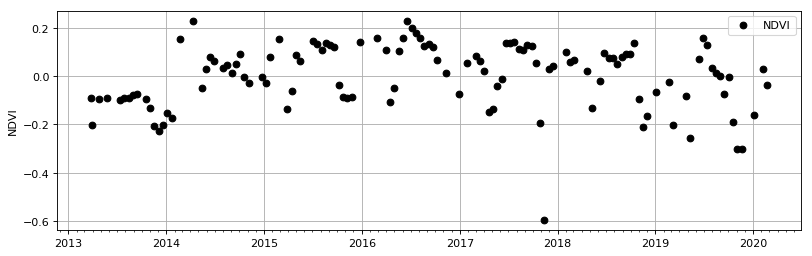

In [126]:
# // Plot the detrended results.
# var detrendedChart = ui.Chart.image.series(detrended, roi, null, 30)
#     .setOptions({
#       title: 'Detrended Landsat time series at ROI',
#       lineWidth: 1,
#       pointSize: 3,
#     });
# print(detrendedChart);

fig = figure(figsize=(12,8), dpi=80)

# plot detrended
ax2 = fig.add_subplot(211)
ax2.plot(time, yData[:,0], 'o', color="black", label="NDVI")
ax2.legend(loc='best')
ax2.grid(True)
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start, end, 64.5))

# Format the ticks.
years    = mdates.YearLocator()   # every year
months   = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax2.set_ylabel('NDVI')

ax2.xaxis.set_major_locator(years)
ax2.xaxis.set_major_formatter(yearsFmt)
ax2.xaxis.set_minor_locator(months)

### d. Estimate seasonality with a harmonic model

Consider the following linear model, where et is a random error, A is amplitude, ω is frequency, and φ is phase:

pt = β0 + β1t + Acos(2πωt - φ) + et 

    = β0 + β1t + β2cos(2πωt) + β3sin(2πωt) + et		(2)

Note that β2 = Acos(φ) and β3 = Asin(φ), implying A = (β22 + β32)½ and φ = atan(β3/β2).  (See Shumway and Stoffer (2017) equations 4.1 - 4.2).  To fit this model to the time series, set ω=1 (one cycle per unit time) and use ordinary least squares regression.

- The setup for fitting the model is to first add the harmonic variables (the third and fourth terms of equation 2) to the image collection.


In [127]:
# // Use these independent variables in the harmonic regression.
harmonicIndependents = ee.List(['constant', 't', 'cos', 'sin']);

# // Add harmonic terms as new image bands.
def harmonic_terms(image):
    timeRadians = image.select('t').multiply(2 * 3.1416)
    return image.\
    addBands(timeRadians.cos().rename('cos')).\
    addBands(timeRadians.sin().rename('sin'))


harmonicLandsat = filteredLandsat.map(harmonic_terms)

- Fit the model as with the linear trend, using the linearRegression() reducer:


In [128]:
harmonicTrend = harmonicLandsat.\
  select(harmonicIndependents.add(dependent)).\
  reduce(ee.Reducer.linearRegression(
    numX= harmonicIndependents.length(), 
    numY= 1
  ))


- Plug the coefficients in to equation 2 in order to get a time series of fitted values:


In [129]:
# // Turn the array image into a multi-band image of coefficients.
harmonicTrendCoefficients = harmonicTrend.select('coefficients').\
  arrayProject([0]).\
  arrayFlatten([harmonicIndependents]);

# // Compute fitted values.
def fitting_harm(image):
    return image.addBands(
    image.select(harmonicIndependents).\
      multiply(harmonicTrendCoefficients).\
      reduce('sum').\
      rename('fitted'))


fittedHarmonic = harmonicLandsat.map(fitting_harm)

In [130]:
info = fittedHarmonic.getRegion(roi,30).getInfo()

We separate the information returned into column headers and data.

In [131]:
# extract the header column names
print(info[0])
header =info[0]
# create a Numpy array of the data
data = array(info[1:])

['id', 'longitude', 'latitude', 'time', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'sr_aerosol', 'pixel_qa', 'radsat_qa', 'NDVI', 't', 'constant', 'cos', 'sin', 'fitted']


Next we extract time information and convert it to at Python datatime data type.

In [132]:
# extract the time information
iTime = header.index('time')
# convert to Python datetime objects
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

In [133]:
xBand = 'time'
yBandList = [
        'NDVI',
        'fitted'
        ]

In [134]:
iBands = [header.index(b) for b in yBandList]
yData = data[0:,iBands].astype(np.float)

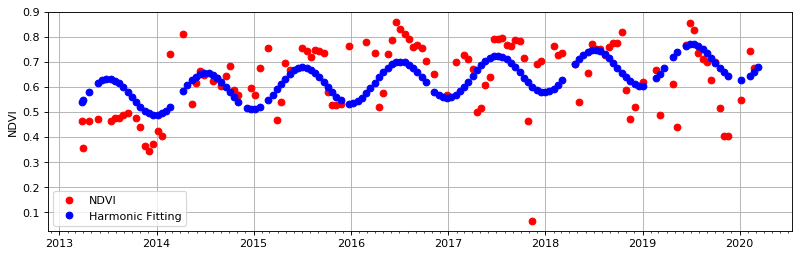

In [135]:
# // Plot the detrended results.
# var detrendedChart = ui.Chart.image.series(detrended, roi, null, 30)
#     .setOptions({
#       title: 'Detrended Landsat time series at ROI',
#       lineWidth: 1,
#       pointSize: 3,
#     });
# print(detrendedChart);

fig = figure(figsize=(12,8), dpi=80)

# plot detrended
ax2 = fig.add_subplot(211)
ax2.plot(time, yData[:,-2], 'o', color="red", label="NDVI")
ax2.plot(time, yData[:,-1], 'o', color="blue",  label="Harmonic Fitting")
ax2.legend(loc='best')
ax2.grid(True)
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start, end, 64.5))

# Format the ticks.
years    = mdates.YearLocator()   # every year
months   = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax2.set_ylabel('NDVI')

ax2.xaxis.set_major_locator(years)
ax2.xaxis.set_major_formatter(yearsFmt)
ax2.xaxis.set_minor_locator(months)

- Although any coefficients can be mapped directly, it is useful and interesting to map the phase and amplitude of the estimated harmonic model.  First, compute phase and amplitude from the coefficients, then map:

In [136]:
# // Compute phase and amplitude.
phase = harmonicTrendCoefficients.select('sin').\
    atan2(harmonicTrendCoefficients.select('cos')).\
    unitScale(-3.1416, 3.1416);
    
amplitude = harmonicTrendCoefficients.select('sin').\
    hypot(harmonicTrendCoefficients.select('cos')).\
    multiply(5);#     // Add a scale factor for visualization.

# // Compute the mean NDVI.
meanNdvi= filteredLandsat.select('NDVI').mean();

# // Use the HSV to RGB transform to display phase and amplitude.
rgb = ee.Image.cat([
  phase,      #// hue
  amplitude,  #// saturation (difference from white)
  meanNdvi    #// value (difference from black)
]).hsvToRgb();

Map.addLayer(rgb, {}, 'phase (hue), amplitude (sat), ndvi (val');


- More on harmonic models

It's worth noting that a time series can be decomposed as the sum of sinusoids at different frequencies (See Shumway and Stoffer (2017), equation 4.7).  The harmonic model presented here can be easily extended in this manner by adding bands that represent higher frequencies (e.g. timeRadians.multiply(2).cos().rename('cos2') and the corresponding sin() band for a harmonic component with two cycles per year) and amending the harmonicIndependents variable accordingly.  If you're feeling plucky, check out this implementation of that idea for an arbitrary number of harmonic terms.  While this will undoubtedly improve the goodness-of-fit of the model, many of the coefficients may be close zero.  To estimate the importance of terms representing seasonality or higher-frequency harmonic behavior (e.g. double-cropping), an F-statistic can be used when the model assumptions are satisfied.  See for example, Shumway and Stoffer (2017), equation 2.11.


### 4. Autocovariance and autocorrelation
The autocovariance of a time series refers to the dependence (specifically the covariance) of values in the time series at time t with values at time h = t − l, where l is the lag.  The autocorrelation is the covariance normalized by the standard deviations of the covariates.  Specifically, assume our time series is stationary and define the autocovariance and autocorrelation according to Shumway and Stoffer (2017) equations 1.27 and 1.26, respectively.  Comparing values at time t to previous values is useful not only for computing autocovariance, but also for a variety of other time series analyses as well, as you'll see shortly.  

To combine image data with previous values, in Earth Engine, the first step is to join the previous values to the current values.  To do that, use a join to create what we'll call a lagged collection:

a. **Create a lagged ImageCollection**

Consider the following function to create a lagged collection:


In [137]:
def lag(leftCollection, rightCollection, lagDays):
    filter = ee.Filter.And(ee.Filter.maxDifference(
      difference= 1000 * 60 * 60 * 24 * lagDays,
      leftField= timeField, 
      rightField= timeField
    ), 
    ee.Filter.greaterThan(
      leftField= timeField, 
      rightField= timeField
  ))
    return ee.Join.saveAll(
    matchesKey= 'images',
    measureKey= 'delta_t',
    ordering= timeField, 
    ascending= False).apply(
    primary= leftCollection, 
    secondary= rightCollection, 
    condition=filter
  )

This function joins a collection to itself, using a filter that gets all the images before but within a specified time difference (in days) of each image.  That list of previous images within the lag time is stored in a property of the image called images, sorted reverse chronologically.  For example, to create a lagged collection from the detrended Landsat imagery:


In [138]:
lagged17 = lag(detrended, detrended, 17);


Why 17 days?  Recall that the temporal cadence of Landsat is 16 days.  Specifying 17 days in the join gets one previous image, but no more.  To compute autocovariance or other interesting statistics, map functions over the lagged collection as in the following sections.


b. **Compute autocovariance and autocorrelation**

- The autocovariance reducer expects a set of one-dimensional arrays as input.  So pixel values corresponding to time t need to be stacked with pixel values at time t − l as multiple bands in the same image.  Consider the the following function for that purpose:


In [139]:
def merger(current, previous):
    return ee.Image(previous).addBands(current)


def merge(image):
#   // Function to be passed to iterate.
    return ee.ImageCollection.fromImages(image.get('images')).iterate(merger, image);



		...and use that function to merge the bands from the lagged collection:


In [140]:
merged17 = ee.ImageCollection(lagged17.map(merge));


- Now the bands from time t and h are all in the same image.  Note that the band name of ph was the same as pt.  During the merging process, it gets a '_1' appended to it.  Use a function to convert the merged bands to arrays with bands pt and ph, then reduce with the covariance reducer:

In [141]:
def imarray(image):
    return image.toArray();


def covariance(mergedCollection, band, lagBand):
    return mergedCollection.select([band, lagBand]).map(imarray).reduce(ee.Reducer.covariance(), 8);


lagBand = dependent.cat('_1');
covariance17 = ee.Image(covariance(merged17, dependent, lagBand))

- The output of the covariance reducer is an array image, in which each pixel stores a 2x2 variance-covariance array.  The off diagonal elements are covariance, which you can map directly:

In [142]:
# Map.addLayer(covariance17.arrayGet([0, 1]), {'max': 0.1,'min':-0.1,'palette':['white', 'blue']}, 'covariance (lag=17 days)');


- The diagonal elements of the variance-covariance array are variances.  Use this function to compute correlation from the variance-covariance array:

In [143]:
def correlation(vcArrayImage):
    covariance = ee.Image(vcArrayImage).arrayGet([0, 1]);
    sd0 = ee.Image(vcArrayImage).arrayGet([0, 0]).sqrt();
    sd1 = ee.Image(vcArrayImage).arrayGet([1, 1]).sqrt();
    return covariance.divide(sd0).divide(sd1).rename('correlation')



		...and map the correlation:


In [144]:
correlation17 = correlation(covariance17);
Map.addLayer(correlation17, {min: -1, max: 1,'palette':['blue','white', 'red']}, 'correlation (lag = 17 days)');


It's worth noting that you can do this for longer lags as well (try 34 days) in Cell 34.  Of course, that images list will fill up with all the images that are within l of t.  Those other images are also useful, for example in fitting autoregressive models as described later.

### 5 Cross-covariance and Cross-correlation

Cross-covariance is analogous to auto-covariance, except instead of measuring the correspondence between a variable and itself at a lag, it measure the correspondence between a variable and a covariate at a lag.  Specifically, define the cross-covariance and cross-correlation according to Shumway and Stoffer (2017) equations 1.30 and 1.31, respectively.  

You already have all the code needed to compute cross-covariance and cross-correlation!  But you do need a time series of another variable.  Suppose we postulate that NDVI is related in some way to the precipitation before the NDVI was observed.  To estimate the strength of this relationship (in every pixel), load precipitation, join, merge, and reduce as previously:


In [145]:
# // Precipitation (covariate)
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD');

# // Join the t-l (l=1 pentad) precipitation images to the Landsat.
lag1PrecipNDVI = lag(filteredLandsat, chirps, 5);

# // Add the precipitation images as bands.
merged1PrecipNDVI = ee.ImageCollection(lag1PrecipNDVI.map(merge));

# // Compute and display cross-covariance.
cov1PrecipNDVI = covariance(merged1PrecipNDVI, 'NDVI', 'precipitation');
# Map.addLayer(cov1PrecipNDVI.arrayGet([0, 1]), {}, 'NDVI - PRECIP cov (lag = 5)');

# // Compute and display cross-correlation.
corr1PrecipNDVI = correlation(cov1PrecipNDVI);
Map.addLayer(corr1PrecipNDVI, {min: -1, max: 1,'palette':['blue','white', 'red']}, 'NDVI - PRECIP corr (lag = 5)');


What do you observe from this result?  Specifically, how can we do better?  One possible drawback of this computation is that it's only based on five days of precipitation, whichever five days came right before the NDVI image.  Perhaps precipitation in the month before the observed NDVI is relevant?  Test that idea with the following:

In [146]:
# // Join the precipitation images from the previous month
lag30PrecipNDVI = lag(filteredLandsat, chirps, 30);
# print(lag30PrecipNDVI.getInfo());

def imagesum(image):
    laggedImages = ee.ImageCollection.fromImages(image.get('images'));
    return ee.Image(image).addBands(laggedImages.sum().rename('sum'));


sum30PrecipNDVI = ee.ImageCollection(lag30PrecipNDVI.map(imagesum));

# // Compute covariance.
cov30PrecipNDVI = covariance(sum30PrecipNDVI, 'NDVI', 'sum');
# Map.addLayer(cov1PrecipNDVI.arrayGet([0, 1]), {}, 'NDVI - sum cov (lag = 30)');

# // Correlation.
corr30PrecipNDVI = correlation(cov30PrecipNDVI);
Map.addLayer(corr30PrecipNDVI, {min: -0.5, max: 0.5,'palette':['blue','white', 'red']}, 'NDVI - sum corr (lag = 30)');


Observe that the only change is to the merge() method.  Instead of merging the bands of the NDVI image and the covariate (precipitation), the entire list of precipitation is summed and added as a band (eliminating the need for iterate()).

As long as there is sufficient temporal overlap between the time series, these techniques can be extended to longer lags and longer time series.  But watch out.  There are some nuances to determining the statistical significance of correlation estimates.  See Shumway and Stoffer (2017) example 1.26 for details.


### 6. Auto-regressive models

The discussion of autocovariance preceded this section in order to introduce the concept of lag.  Now that you have a way to get previous values of a variable, it's worth considering auto-regressive models.  Suppose that pixel values at time t depend in some way on previous pixel values.  If you have observed significant, non-zero autocorrelations in a time series, this may not be a crazy assumption.  Specifically, you may postulate a linear model such as:

pt = β0 + β1pt-1 + β2pt-2 + et					(3)

To fit this model, you need a lagged collection as created previously except with a longer lag (e.g. l = 34 days).  The next steps are to merge the bands, then reduce with the linear regression reducer.

- Create a lagged collection, where the images list stores the two previous images:

In [147]:
lagged34 = ee.ImageCollection(lag(filteredLandsat, filteredLandsat, 34));


- Merge the bands of the lagged collection such that each image has bands at time t and bands at times t-1,..., t − l.  Note that it's necessary to filter out any images that don't have two previous temporal neighbors:

In [148]:
def imlist(image):
    return image.set('n', ee.List(image.get('images')).length())


merged34 = lagged34.map(merge).map(imlist).filter(ee.Filter.gt('n', 1));


- Fit the regression model using the linearRegression() reducer:


In [149]:
arIndependents = ee.List(['constant', 'NDVI_1', 'NDVI_2']);

ar2 = merged34.\
  select(arIndependents.add(dependent)).\
  reduce(ee.Reducer.linearRegression(arIndependents.length(), 1));

# // Turn the array image into a multi-band image of coefficients.
arCoefficients = ar2.select('coefficients').\
  arrayProject([0]).\
  arrayFlatten([arIndependents]);


- Compute the fitted values using an expression.  Because this model is a function of previous pixel values, which may be masked, if any of the inputs to equation 3 are masked, the output of the equation will also be masked.  That's why you should use an expression here, unlike the previous linear models of time.

In [150]:
# // Compute fitted values.
def imcoefs(image):
    return image.addBands(
        image.expression('beta0 + beta1 * p1 + beta2 * p2', {
          'p1':image.select('NDVI_1'),
          'p2': image.select('NDVI_2'),
          'beta0': arCoefficients.select('constant'),
          'beta1': arCoefficients.select('NDVI_1'),
          'beta2': arCoefficients.select('NDVI_2')
            }).rename('fitted'));
    
fittedAR = merged34.map(imcoefs)


- Plot the results.  Note the missing values that result from masked data.


In [151]:
info = fittedAR.getRegion(roi,30).getInfo()

We separate the information returned into column headers and data.

In [152]:
# extract the header column names
print(info[0])
header =info[0]
# create a Numpy array of the data
data = array(info[1:])

['id', 'longitude', 'latitude', 'time', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'sr_aerosol', 'pixel_qa', 'radsat_qa', 'NDVI', 't', 'constant', 'B1_1', 'B2_1', 'B3_1', 'B4_1', 'B5_1', 'B6_1', 'B7_1', 'B10_1', 'B11_1', 'sr_aerosol_1', 'pixel_qa_1', 'radsat_qa_1', 'NDVI_1', 't_1', 'constant_1', 'B1_2', 'B2_2', 'B3_2', 'B4_2', 'B5_2', 'B6_2', 'B7_2', 'B10_2', 'B11_2', 'sr_aerosol_2', 'pixel_qa_2', 'radsat_qa_2', 'NDVI_2', 't_2', 'constant_2', 'fitted']


Next we extract time information and convert it to at Python datatime data type.

In [153]:
# extract the time information
iTime = header.index('time')
# convert to Python datetime objects
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

In [154]:
xBand = 'time'
yBandList = [
        'NDVI',
        'fitted'
        ]

In [155]:
iBands = [header.index(b) for b in yBandList]
yData = data[0:,iBands].astype(np.float)

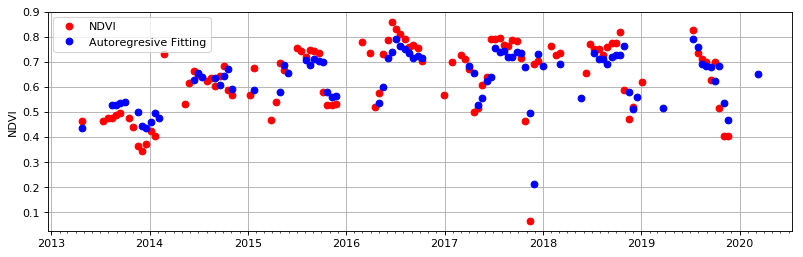

In [156]:
# // Plot the detrended results.
# var detrendedChart = ui.Chart.image.series(detrended, roi, null, 30)
#     .setOptions({
#       title: 'Detrended Landsat time series at ROI',
#       lineWidth: 1,
#       pointSize: 3,
#     });
# print(detrendedChart);

fig = figure(figsize=(12,8), dpi=80)

# plot detrended
ax2 = fig.add_subplot(211)
ax2.plot(time, yData[:,-2], 'o', color="red", label="NDVI")
ax2.plot(time, yData[:,-1], 'o', color="blue",  label="Autoregresive Fitting")
ax2.legend(loc='best')
ax2.grid(True)
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start, end, 64.5))

# Format the ticks.
years    = mdates.YearLocator()   # every year
months   = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax2.set_ylabel('NDVI')

ax2.xaxis.set_major_locator(years)
ax2.xaxis.set_major_formatter(yearsFmt)
ax2.xaxis.set_minor_locator(months)

At this stage, note that the missing data has become a real problem.  Any data point for which at least one of the previous points is masked or missing is also masked.  It may be possible to avoid this problem by substituting the output from equation 3 (the modeled value) for the missing or masked data.  Unfortunately, the code to make that happen is not straightforward.  If you're feeling brave, check out [this solution](https://code.earthengine.google.com/c5fbadc5136d94e80ba428376b05d148).


## Assignment:
    
Create a notebook, change the location (the roi coordinates in Cell 4) ane evaluate the capability of harmonic and autoregression approaches to estimate NDVI and the relationship between Precipitation and NDVI in one of these sites:

a) Desert location (Death Valley in CA), 
b) The Nile Delta 

Or you can do two notebooks and see how these different enviroments behave in a time series analysis.

Happy Coding
